<h1 align="center"><b>Malaria Cell Classifier</b></h1>

<h3 align="center">Building an efficient  Convolutional Neural Network (CNN) model for classifying the Malaria image cells dataset</h3>

---
---
## Table of Contents

1. [Introduction](#Introduction)
2. [Data Loading and Preprocessing](#Data-Loading-and-Preprocessing)
   - 2.1 [Pre-Processing Summary](#Pre-Processing-Summary)
3. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
4. [Model Building](#Model-Building)
   - 4.1 [Model Architecture](#Model-Architecture)
   - 4.2 [Model Compilation](#Model-Compilation)
5. [Training the Model](#Training-the-Model)
   - 5.1 [Data Partitioning](#Data-Partitioning)
   - 5.2 [Implementing Data Augmentation](#Implementing-Data-Augmentation)
   - 5.3 [Configuring Training Callbacks](#Configuring-Training-Callbacks)
   - 5.4 [Executing Model Training](#Executing-Model-Training)
6. [Model Evaluation](#Model-Evaluation)
   - 6.1 [Evaluation Metrics](#Evaluation-Metrics)
   - 6.2 [Confusion Matrix](#Confusion-Matrix)
   - 6.3 [ROC Curve and AUC](#ROC-Curve-and-AUC)
   - 6.4 [Visual Inspection of Model Predictions](#Visual-Inspection-of-Model-Predictions)

---
---

## Introduction

In this notebook, we delve into the critical task of classifying cells as either parasitized (infected) or uninfected, employing a Convolutional Neural Network (CNN) to analyze microscopic images of blood cells, a process that traditionally requires extensive manual effort and expert knowledge in microscopy. By automating this process, we aim to enhance the speed and accuracy of malaria diagnosis, potentially saving lives through earlier and more efficient treatment interventions. This notebook is structured to guide you through each step of our methodology, from data preprocessing and exploratory analysis to model training and evaluation. 

---
---

## Data Loading and Preprocessing

In [1]:
# Extend system path to include 'Scripts' and 'Utilities' directories for module imports
import sys
sys.path.extend(['../Scripts', '../Utilities'])

In [2]:
# Importing general utility functions from the 'import_libraries' module
from import_libraries import get_general_utils

# Getting the Path and os modules from the general utilities
Path, os = get_general_utils()

# Setting the path to the dataset. 
dataset_path = Path("path/to/your/dataset/directory")

In [3]:
# Import Image Processing utilities
from image_processing import load_and_preprocess_images

# Define constants
SIZE = 64
COLOR_MODE = 'rgb'  

# Initialize lists for dataset and labels
infected_data, infected_labels = load_and_preprocess_images(dataset_path/'Parasitized', SIZE, COLOR_MODE)
uninfected_data, uninfected_labels   = load_and_preprocess_images(dataset_path/'Uninfected' , SIZE, COLOR_MODE)

# Combine the datasets and labels
dataset = infected_data   + uninfected_data
labels  = infected_labels + uninfected_labels

# Display basic statistics
print(f"Total images: {len(dataset)}")
print(f"Number of 'Infected' images: {len(infected_data)}")
print(f"Number of 'Uninfected' images:  {len(uninfected_data)}")

Total images: 27558
Number of 'Infected' images: 13779
Number of 'Uninfected' images:  13779


### Pre-Processing Summary

In the data preparation stage [**/Utilities/image_processing.py**], several key pre-processing steps were undertaken to ensure the images were suitable for analysis:
 
- **Loading Images**: Images were loaded from two distinct directories, representing the 'Parasitized' and 'Uninfected' classes.

- **Resizing Images**: To maintain consistency and reduce computational load, each image was resized to a uniform dimension of 64x64 pixels.

- **Color Conversion**: The original images were converted to the RGB color mode. This step is crucial as it standardizes the color representation of the images, ensuring that the model receives inputs in a consistent format.

- **Label Assignment**: Labels were assigned to the images based on their directory of origin. Images from the 'Parasitized' directory were labeled as 0, and those from the 'Uninfected' directory as 1. This binary labeling is a key step in preparing the dataset for a supervised classification task.

These pre-processing steps are critical in transforming raw image data into a structured format that can be effectively used for machine learning modeling.

---
---

## Exploratory Data Analysis

In [4]:
# Import EDA utilities
from eda_utils import display_image_samples, plot_class_distribution

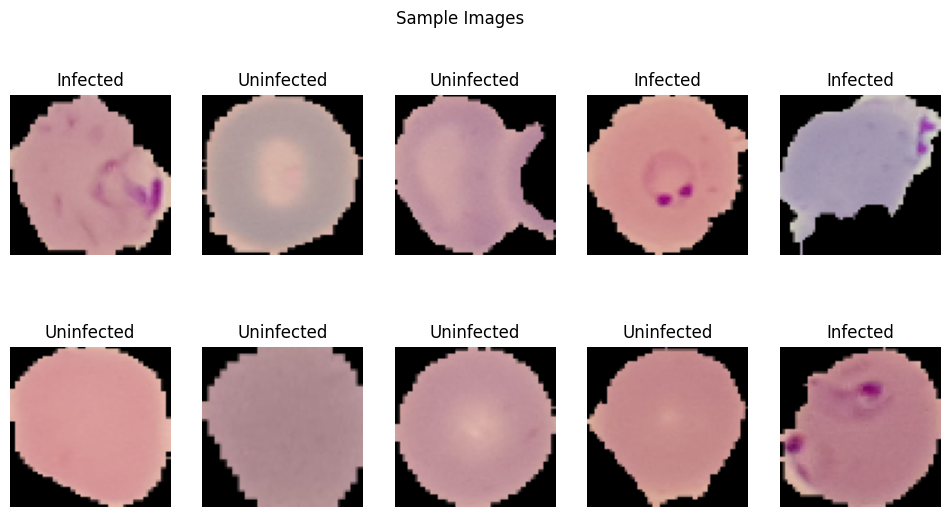

In [6]:
from import_libraries import get_data_handling_and_viz_libs
np, plt, sns, cv2 = get_data_handling_and_viz_libs()

# Plot some random samples from the dataset with their labels
samples_to_display = 10

random_indices = np.random.choice(len(dataset), samples_to_display, replace=False)
samples = [dataset[i] for i in random_indices]
sample_labels = [labels[i] for i in random_indices]

# Example usage
display_image_samples(samples, sample_labels, sample_size = samples_to_display)

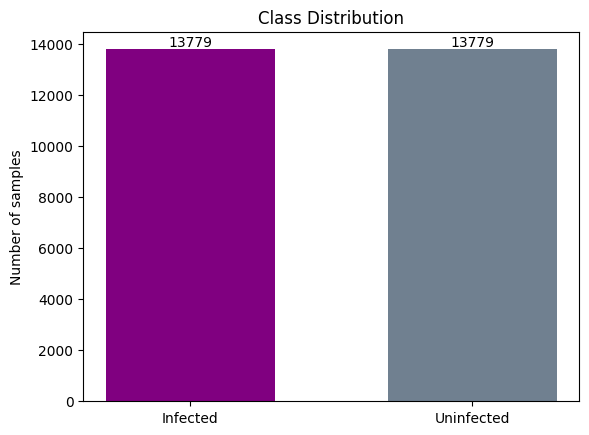

In [7]:
# Plot class distribution
plot_class_distribution(labels)

#### **NOTE:**

Our dataset consists of an equal number of images for both 'Infected' and 'Uninfected' categories, as illustrated in the class distribution plot above. This equal distribution signifies that our dataset is **well-balanced**.

---
---

## Model Building

In this section, we focus on constructing and compiling our Convolutional Neural Network (CNN) model for the task of classifying malaria-infected cells. The process involves two primary stages:

- **Model Architecture**: Here, we define the structure of our CNN, including the layers, their types, and how they are connected. The architecture is a crucial aspect as it determines how effectively the model can learn from our image data.

- **Model Compilation**: After defining the architecture, we compile the model. This step involves specifying the optimizer, loss function, and metrics for evaluating the model’s performance. The compilation settings play a vital role in how the model learns during the training process.


### Model Architecture

In [ ]:
# Import necessary layers and functions
from import_libraries import get_core_keras_layers, get_training_components

# Get core keras layers
Input, Conv2D, Dense, Flatten, BatchNormalization, Dropout, Model = get_core_keras_layers()
# Get training components
l2, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard = get_training_components()

In [9]:
# Define convolution block
def conv_block(input_tensor, num_filters):
    """
    Adds a convolutional block to the model.

    Parameters:
    - input_tensor: Input tensor to the convolutional block
    - num_filters: Number of filters for the convolutional layers

    Returns:
    - Tensor after applying convolutional layers, BatchNormalization, and Dropout
    """
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(input_tensor)
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    return x

# Define dense block
def dense_block(input_tensor, num_neurons):
    """
    Adds a dense block to the model.

    Parameters:
    - input_tensor: Input tensor to the dense block
    - num_neurons: Number of neurons in the dense layer

    Returns:
    - Tensor after applying Dense layer, BatchNormalization, and Dropout
    """
    x = Dense(num_neurons, activation='relu', kernel_regularizer=l2(0.001))(input_tensor)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    return x

# Define the input shape
INPUT_SHAPE = (SIZE, SIZE, 3)

# Input layer
inp = Input(shape=INPUT_SHAPE)

# Creating convolutional blocks
x = conv_block(inp, 32)
x = conv_block(x, 32)
x = conv_block(x, 64)
x = conv_block(x, 64)

# Flattening and dense layers
x = Flatten()(x)
x = dense_block(x, 512)
x = dense_block(x, 256)

# Output layer for binary classification
out = Dense(2, activation='softmax')(x)

# Final Model Construction
model = Model(inputs=inp, outputs=out)


### Model Compilation

In [10]:
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow as tf

# Configure the optimizer 
optimizer = Adam(learning_rate=0.001)

# Compile the model with explicit configurations
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',  # Standard loss for binary classification
              metrics=[
                  'accuracy',  # Overall classification accuracy
                  tf.keras.metrics.Precision(name='precision'), 
                  tf.keras.metrics.Recall(name='recall') 
              ])

# Print model summary
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                             

---
---

## Training the Model

In [11]:
from import_libraries import get_data_preprocessing_tools, get_sklearn_components, get_keras_utilities

### Data Partitioning

In [12]:
# Get Scikit-learn components
train_test_split, _, _, _, _ = get_sklearn_components()

# Get Keras utilities
to_categorical = get_keras_utilities()

# Splitting the Dataset into Training + Validation and Test sets
X = np.array(dataset)
Y = to_categorical(np.array(labels))

# Splitting the data into a combined (training + validation) set, and a separate test set.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# Splitting the (Training + Validation) set into individual Training and Validation sets
X_train, X_val, y_train, y_val  = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (16534, 64, 64, 3)
y_train shape: (16534, 2)
X_test shape: (5512, 64, 64, 3)
y_test shape: (5512, 2)
X_val shape: (5512, 64, 64, 3)
y_val shape: (5512, 2)


### Implementing Data Augmentation

In [13]:
# Get data preprocessing tools
ImageDataGenerator = get_data_preprocessing_tools()

# Define the ImageDataGenerator
data_generator = ImageDataGenerator(
    rotation_range    = 15,
    width_shift_range = False,
    height_shift_range= False,
    zoom_range        = False,
    horizontal_flip   = True,
    vertical_flip     = True
)

# to create the augmented data generator
augmented_data = data_generator.flow(X_train, y_train, batch_size = 64)

### Configuring Training Callbacks

In [14]:
l2, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard = get_training_components()

#### Model Checkpoint
*   Callback to save the model with the best validation loss
*   This ensures that we always save the model in its best-performing state on the validation data

In [15]:
model_checkpoint = ModelCheckpoint(
    filepath = '/Models/best_CNN_for_Malaria_classifier.keras',
    monitor  = 'accuracy',  #'val_loss',
    save_best_only = True,
    verbose  = 1,
    mode     = 'max'    # The target, 'val_loss', should be minimized
)

#### Early Stopping
*   Callback to stop training when the validation loss stops improving
*   This helps in preventing overfitting and reduces unnecessary training time

In [16]:
early_stopping = EarlyStopping(
    monitor  = 'val_loss',
    patience = 5,
    verbose  = 1,
    mode     = 'min'    
)

#### Adjusting the learning rate
*   Callback to reduce the learning rate when a metric has stopped improving
*   This helps in achieving smoother convergence through training

In [17]:
reduce_lr = ReduceLROnPlateau(
    monitor  = 'val_loss', 
    factor   = 0.1,   # Multiplicative factor of learning rate reduction
    patience = 5,
    min_lr   = 0.0001, # Lower bound on the learning rate
    verbose  = 1
)

In [18]:
# List of callbacks to be used in model training
callbacks_list = [model_checkpoint, early_stopping, reduce_lr]

### Executing Model Training

In [19]:
# Training the Model
results = model.fit(
    augmented_data,
    verbose = 1,
    epochs  = 15,
    validation_data = (X_val, y_val),
    steps_per_epoch = len(X_train) // 64,  # Number of batches per epoch
    callbacks = callbacks_list
)

Epoch 1/15
258/258 [==============================] - ETA: 0s - loss: 1.7604 - accuracy: 0.6672 - precision: 0.6672 - recall: 0.6672
Epoch 1: accuracy improved from -inf to 0.66721, saving model to /Volumes/D/GitHub-Portfolio/MalariaPred/Models/best_CNN_for_Malaria_classifier.keras
258/258 [==============================] - 21s 76ms/step - loss: 1.7604 - accuracy: 0.6672 - precision: 0.6672 - recall: 0.6672 - val_loss: 3.3841 - val_accuracy: 0.5644 - val_precision: 0.5644 - val_recall: 0.5644 - lr: 0.0010
Epoch 2/15
258/258 [==============================] - ETA: 0s - loss: 1.0292 - accuracy: 0.9157 - precision: 0.9157 - recall: 0.9157
Epoch 2: accuracy improved from 0.66721 to 0.91566, saving model to /Volumes/D/GitHub-Portfolio/MalariaPred/Models/best_CNN_for_Malaria_classifier.keras
258/258 [==============================] - 20s 79ms/step - loss: 1.0292 - accuracy: 0.9157 - precision: 0.9157 - recall: 0.9157 - val_loss: 0.8816 - val_accuracy: 0.9175 - val_precision: 0.9175 - val_rec

## Model Evaluation

In [20]:
# Get Scikit-learn components
_ , classification_report, confusion_matrix, roc_curve, auc = get_sklearn_components()

### Evaluation Metrics

In [21]:
# Evaluate the model
scores = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print(f"Test Loss: {scores[0]:.5f}")

# Predict classes with the model
predictions = model.predict(np.array(X_test))
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels to single-column format
y_test_single_column = np.argmax(y_test, axis=1)

# Generate classification report and confusion matrix
print(classification_report(y_test_single_column, predicted_classes))

Accuracy: 95.90%
Test Loss: 0.18573
173/173 [==============================] - 3s 14ms/step
              precision    recall  f1-score   support

           0       0.98      0.93      0.96      2797
           1       0.94      0.98      0.96      2715

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



In [22]:
# Calculate the average training loss over all epochs
average_train_loss = np.mean(results.history['loss'])

# Get the training loss from the last epoch
final_train_loss = results.history['loss'][-1]

print(f"Average Training Loss: {average_train_loss:.5f}")
print(f"Final Training Loss: {final_train_loss:.5f}")

Average Training Loss: 0.44453
Final Training Loss: 0.19738


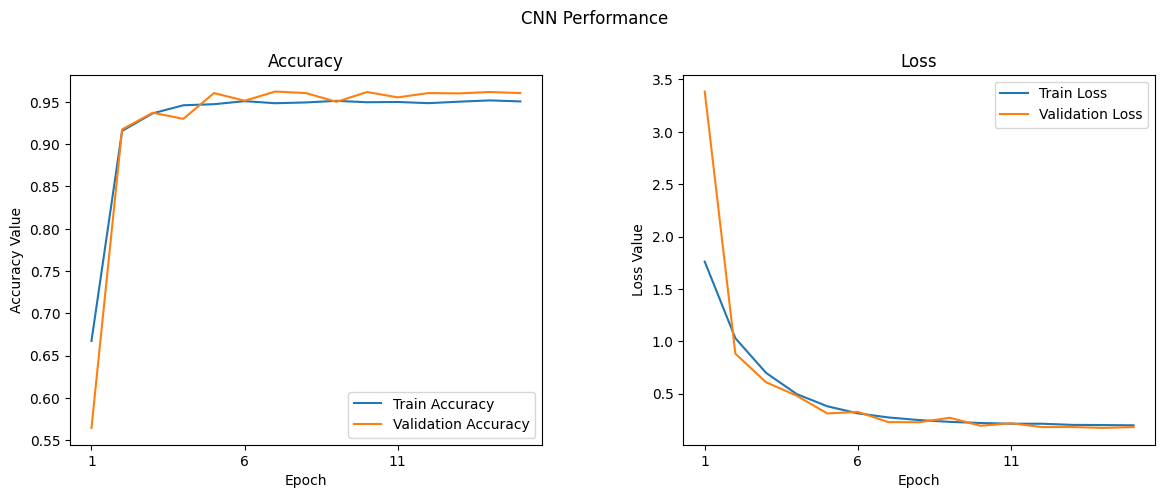

In [23]:
def plot_training_history(results):
    """
    Plot the training and validation accuracy and loss over epochs.

    This function visualizes the model's training progress. It plots two graphs:
    - The first graph shows the training and validation accuracy over epochs.
    - The second graph shows the training and validation loss over epochs.

    Parameters:
    - history: A Keras History object containing the model's training history.

    The function creates a subplot with two axes objects and plots the accuracy and
    loss values stored in the history object.
    """

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('CNN Performance', fontsize=12)
    fig.subplots_adjust(top=0.85, wspace=0.3)

    # Extract the number of epochs and create a list of epoch numbers
    max_epoch = len(results.history['accuracy'])
    epoch_list = list(range(1, max_epoch + 1))

    # Plot training and validation accuracy
    ax1.plot(epoch_list, results.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, results.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(1, max_epoch + 1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    ax1.legend(loc="best")

    # Plot training and validation loss
    ax2.plot(epoch_list, results.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, results.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(1, max_epoch + 1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    ax2.legend(loc="best")

    # Display the plots
    plt.show()

# Call the function to plot
plot_training_history(results)

### Confusion Matrix

In [24]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_single_column, predicted_classes)
print(conf_matrix)

[[2615  182]
 [  44 2671]]


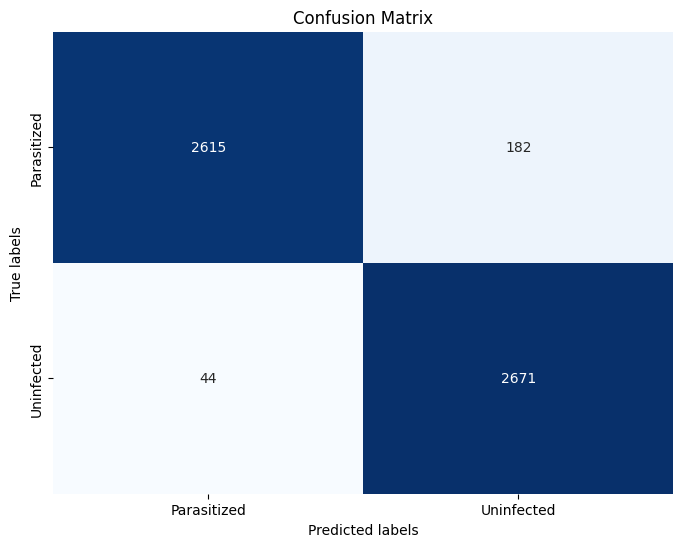

In [25]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Parasitized', 'Uninfected'])
plt.yticks(ticks=[0.5, 1.5], labels=['Parasitized', 'Uninfected'])
plt.show()

### ROC Curve and AUC

In [26]:
# Get the predicted probabilities for the positive class (1)
y_pred_probs = model.predict(X_test)[:, 1]  

# Calculate the Receiver Operating Characteristic (ROC) curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_single_column, y_pred_probs)

# Calculate the Area Under the ROC Curve (AUC) score
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'AUC Score: {roc_auc:.2f}')

173/173 [==============================] - 2s 14ms/step
AUC Score: 0.99


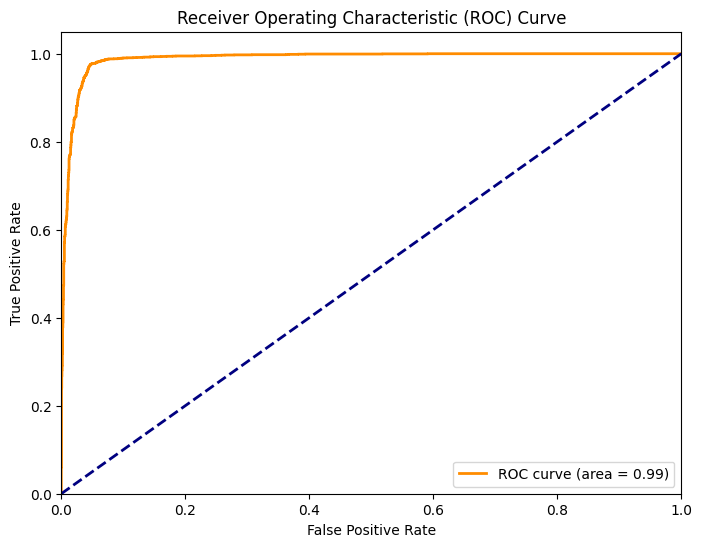

In [27]:
plt.figure(figsize=(8, 6))
plt.plot(false_positive_rate, true_positive_rate, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Visual Inspection of Model Predictions

1/1 [==============================] - 0s 11ms/step


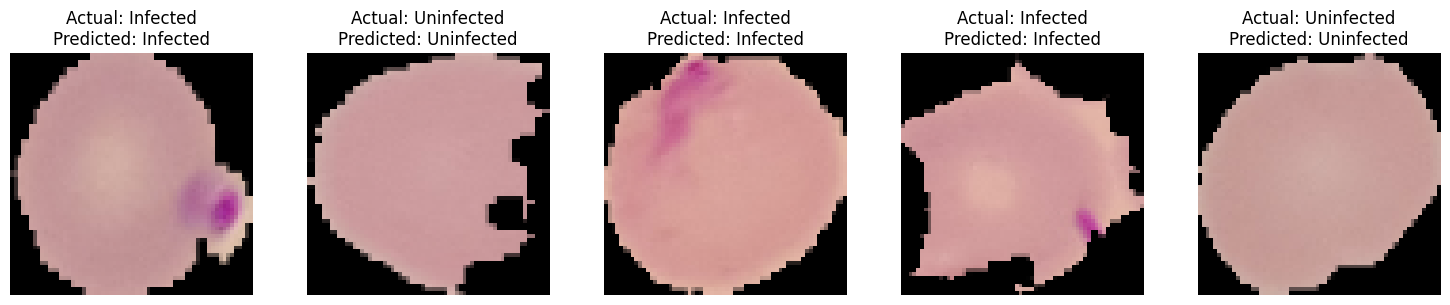

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Define a mapping from class indices to human-readable class names
class_mapping = {0: "Infected", 1: "Uninfected"}

# Number of random samples to display and save
num_samples = 5

# Directory to save the images
save_directory = '/MalariaPred/Images/'  # Update with your desired path

# Create a figure with subplots for displaying
plt.figure(figsize=(15, 3))  # Adjust the figure size as needed

for i in range(num_samples):
    # Randomly pick an index from the test set
    sample_index = np.random.choice(len(X_test))
    # Retrieve the corresponding image and label from the test set
    sample_image = X_test[sample_index]

    # Generate model predictions for the sample image
    predictions = model.predict(np.expand_dims(sample_image, axis=0))
    predicted_class_idx = np.argmax(predictions, axis=1)[0]

    # Save the image without title or axis
    fig = plt.figure()
    plt.imshow(sample_image)
    plt.axis("off")
    plt.savefig(f"{save_directory}predicted_sample_{i+1}.png", bbox_inches='tight', pad_inches=0)
    plt.close(fig)  # Close the figure to free memory

    # Add a subplot for each sample for display
    ax = plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample_image)
    plt.axis("off")  # Hide the axis

    # Add title with the actual and predicted classes (only for display)
    actual_class = np.argmax(y_test[sample_index])
    ax.set_title(f"Actual: {class_mapping[actual_class]}\nPredicted: {class_mapping[predicted_class_idx]}")

plt.tight_layout()  # Adjust the layout for display
plt.show()
